# Trasfer learning model

In [1]:
# !pip install seaborn

In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import classification_report

## Dataset

In [3]:
dataset_path = os.path.join('../../Brain Tumor Data Set')
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path)

dataset

Found 4600 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
class_names = np.array(dataset.class_names)
print(class_names)

['Brain Tumor' 'Healthy']


### Train - test split

In [5]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 3680 files for training.


In [6]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [7]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64,)


## Mobilenet_v2 - model without augmentation, with dense & dropout layer

In [8]:
input_shape = (224, 224, 3)

In [9]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [10]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [11]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(320)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_1 = keras.Model(input, output)

model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 320)               409920    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 321       
Total params: 2,668,225
Trainable params: 410,241
Non-trainable params: 2,257,984
_____________________________________________

In [12]:
model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [13]:
epochs = 60
patience = 5

In [14]:
history_1 = model_1.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/60
58/58 [==============================] - 115s 2s/step - loss: 0.5891 - binary_accuracy: 0.7867 - val_loss: 0.2924 - val_binary_accuracy: 0.8880
Epoch 2/60
58/58 [==============================] - 111s 2s/step - loss: 0.2751 - binary_accuracy: 0.8840 - val_loss: 0.2258 - val_binary_accuracy: 0.9098
Epoch 3/60
58/58 [==============================] - 112s 2s/step - loss: 0.2242 - binary_accuracy: 0.9060 - val_loss: 0.2465 - val_binary_accuracy: 0.9076
Epoch 4/60
58/58 [==============================] - 112s 2s/step - loss: 0.1824 - binary_accuracy: 0.9239 - val_loss: 0.1953 - val_binary_accuracy: 0.9185
Epoch 5/60
58/58 [==============================] - 112s 2s/step - loss: 0.1816 - binary_accuracy: 0.9272 - val_loss: 0.2446 - val_binary_accuracy: 0.9098
Epoch 6/60
58/58 [==============================] - 112s 2s/step - loss: 0.1753 - binary_accuracy: 0.9291 - val_loss: 0.2498 - val_binary_accuracy: 0.8739
Epoch 7/60
58/58 [==============================] - 111s 2s/step - los

In [15]:
history_1.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

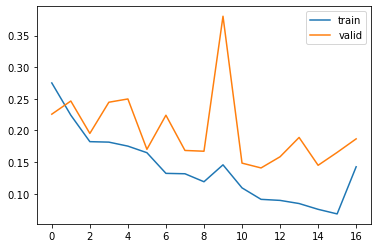

In [16]:
plt.plot(history_1.history['loss'][1:])
plt.plot(history_1.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

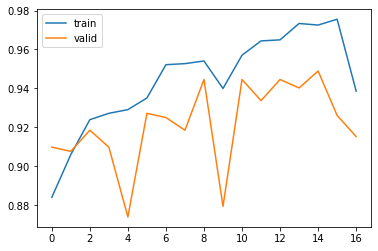

In [17]:
plt.plot(history_1.history['binary_accuracy'][1:])
plt.plot(history_1.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [18]:
x_val_1, y_val_1 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_1 = model_1.predict(x_val_1)
sum((y_pred_1[:, 0] > 0) == y_val_1) / len(y_val_1)

0.9375

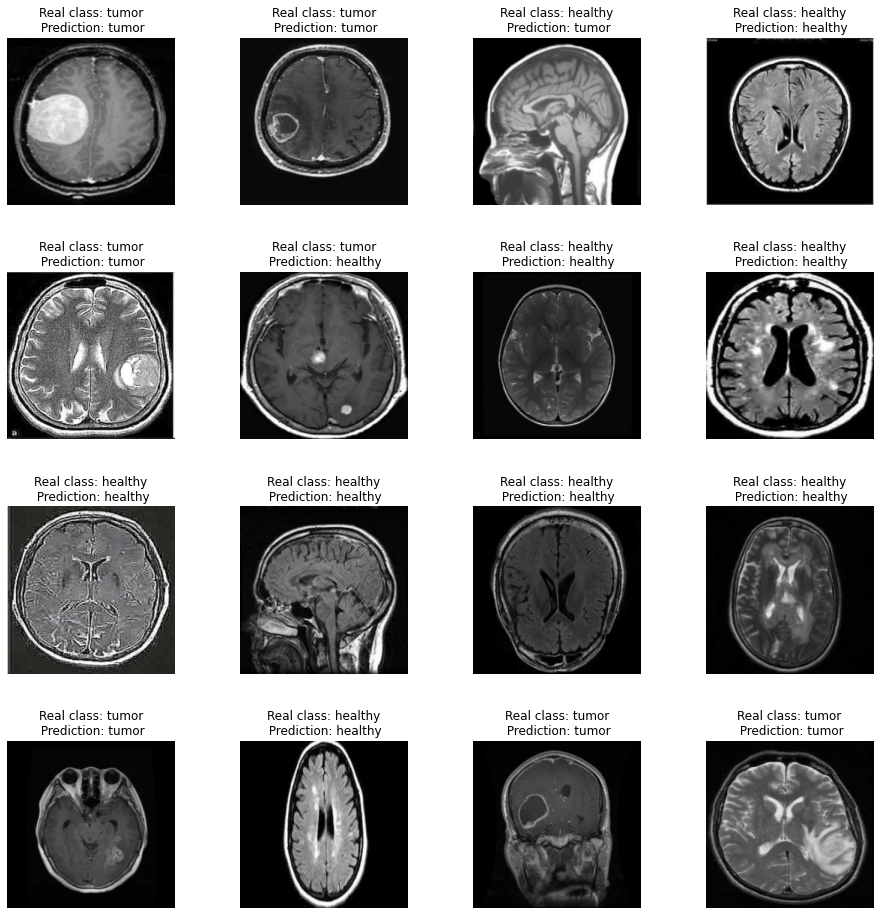

In [19]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_1[i].astype('int32'))
    
    real_y = 'healthy' if y_val_1[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_1[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [20]:
y_pred_1_binary = [1 if y > 0 else 0 for y in y_pred_1]

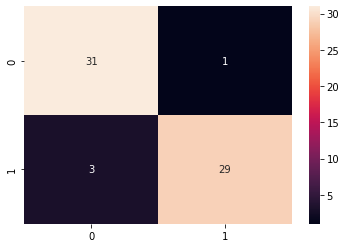

In [21]:
cf = tf.math.confusion_matrix(y_val_1, y_pred_1_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [22]:
print(classification_report(y_val_1, y_pred_1_binary))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        32
           1       0.97      0.91      0.94        32

    accuracy                           0.94        64
   macro avg       0.94      0.94      0.94        64
weighted avg       0.94      0.94      0.94        64



## Inception_v3 - model without augmentation, with dense & dropout layer

In [23]:
input_shape = (256, 256, 3)

In [24]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_2 = keras.Model(input, output)

model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 22,327,585
Trainable params: 524,801
Non-trainable params: 21,802,784
_________________________________________________________________


In [25]:
model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [26]:
epochs = 60
patience = 5

In [27]:
history_2 = model_2.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/60
58/58 [==============================] - 331s 6s/step - loss: 14.4451 - binary_accuracy: 0.6201 - val_loss: 6.2624 - val_binary_accuracy: 0.6087
Epoch 2/60
58/58 [==============================] - 332s 6s/step - loss: 2.6188 - binary_accuracy: 0.7459 - val_loss: 1.5187 - val_binary_accuracy: 0.8120
Epoch 3/60
58/58 [==============================] - 329s 6s/step - loss: 2.1889 - binary_accuracy: 0.7682 - val_loss: 0.8627 - val_binary_accuracy: 0.8522
Epoch 4/60
58/58 [==============================] - 335s 6s/step - loss: 1.4985 - binary_accuracy: 0.8035 - val_loss: 0.7227 - val_binary_accuracy: 0.8674
Epoch 5/60
58/58 [==============================] - 333s 6s/step - loss: 1.2744 - binary_accuracy: 0.8101 - val_loss: 0.7421 - val_binary_accuracy: 0.8543
Epoch 6/60
58/58 [==============================] - 336s 6s/step - loss: 1.2233 - binary_accuracy: 0.8092 - val_loss: 1.7471 - val_binary_accuracy: 0.7859
Epoch 7/60
58/58 [==============================] - 337s 6s/step - lo

In [28]:
history_2.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

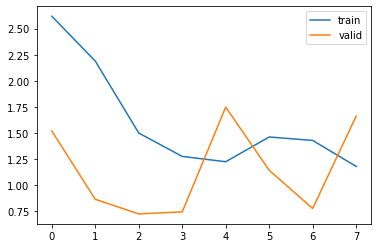

In [29]:
plt.plot(history_2.history['loss'][1:])
plt.plot(history_2.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

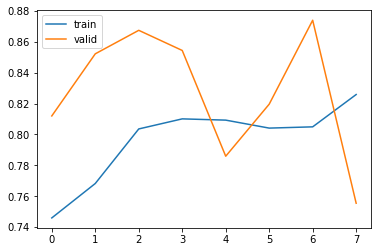

In [30]:
plt.plot(history_2.history['binary_accuracy'][1:])
plt.plot(history_2.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [31]:
x_val_2, y_val_2 = list(tfds.as_numpy(ds_val))[0]
y_pred_2 = model_2.predict(x_val_2)
sum((y_pred_2[:, 0] > 0) == y_val_2) / len(y_val_2)

0.796875

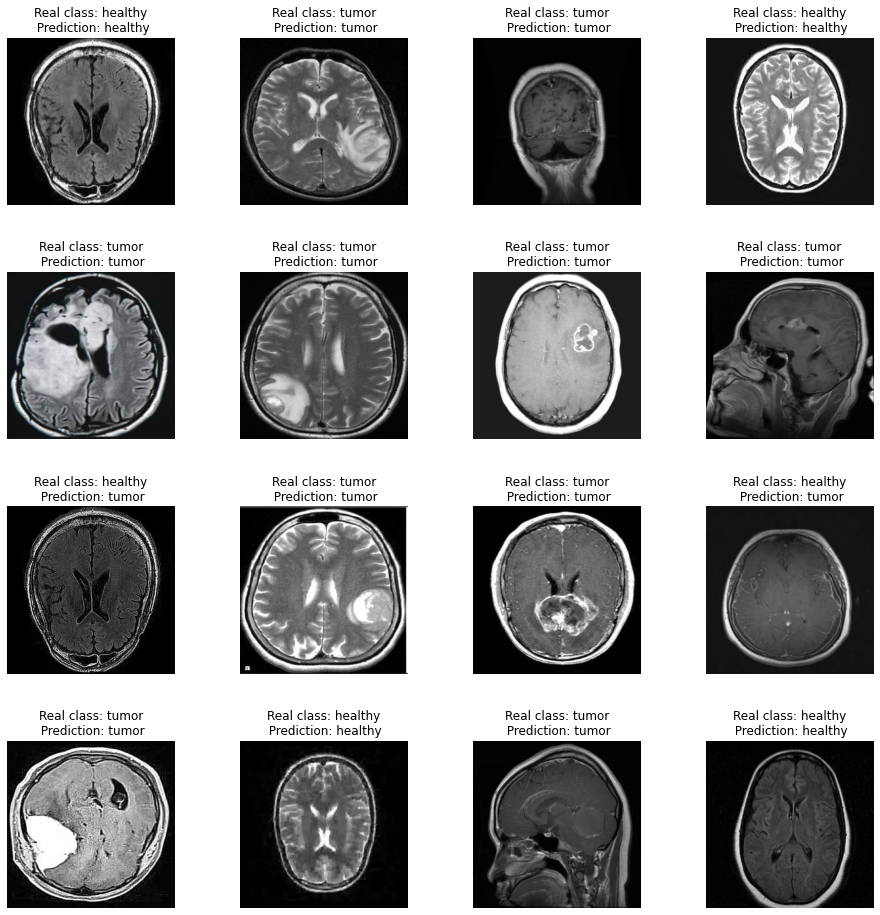

In [32]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_2[i].astype('int32'))
    
    real_y = 'healthy' if y_val_2[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_2[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [33]:
y_pred_2_binary = [1 if y > 0 else 0 for y in y_pred_2]

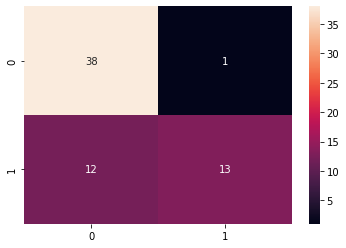

In [34]:
cf = tf.math.confusion_matrix(y_val_2, y_pred_2_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [35]:
print(classification_report(y_val_2, y_pred_2_binary))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85        39
           1       0.93      0.52      0.67        25

    accuracy                           0.80        64
   macro avg       0.84      0.75      0.76        64
weighted avg       0.83      0.80      0.78        64



## Mobilenet_v2 - dropout increase

In [36]:
input_shape = (224, 224, 3)

In [37]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [38]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [39]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(320)(x)
x = keras.layers.Dropout(0.4, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_3 = keras.Model(input, output)

model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 320)               409920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 321       
Total params: 2,668,225
Trainable params: 410,241
Non-trainable params: 2,257,984
___________________________________________

In [40]:
model_3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [41]:
epochs = 60
patience = 5

In [42]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/60
58/58 [==============================] - 125s 2s/step - loss: 0.5623 - binary_accuracy: 0.7886 - val_loss: 0.2757 - val_binary_accuracy: 0.8913
Epoch 2/60
58/58 [==============================] - 124s 2s/step - loss: 0.2719 - binary_accuracy: 0.8867 - val_loss: 0.3386 - val_binary_accuracy: 0.8370
Epoch 3/60
58/58 [==============================] - 123s 2s/step - loss: 0.2560 - binary_accuracy: 0.8981 - val_loss: 0.2116 - val_binary_accuracy: 0.9185
Epoch 4/60
58/58 [==============================] - 124s 2s/step - loss: 0.2253 - binary_accuracy: 0.9068 - val_loss: 0.2394 - val_binary_accuracy: 0.8859
Epoch 5/60
58/58 [==============================] - 122s 2s/step - loss: 0.1911 - binary_accuracy: 0.9261 - val_loss: 0.2019 - val_binary_accuracy: 0.9065
Epoch 6/60
58/58 [==============================] - 124s 2s/step - loss: 0.1616 - binary_accuracy: 0.9342 - val_loss: 0.1843 - val_binary_accuracy: 0.9217
Epoch 7/60
58/58 [==============================] - 122s 2s/step - los

In [43]:
history_3.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

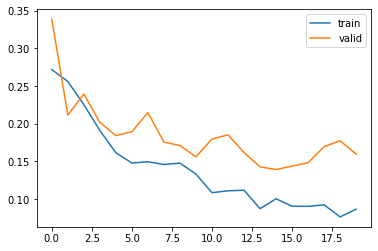

In [44]:
plt.plot(history_3.history['loss'][1:])
plt.plot(history_3.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

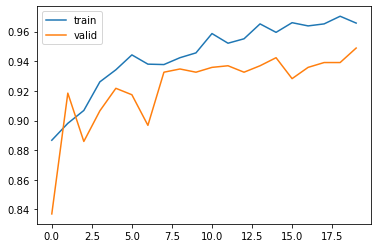

In [45]:
plt.plot(history_3.history['binary_accuracy'][1:])
plt.plot(history_3.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [46]:
x_val_3, y_val_3 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_3 = model_3.predict(x_val_3)
sum((y_pred_3[:, 0] > 0) == y_val_3) / len(y_val_3)

0.96875

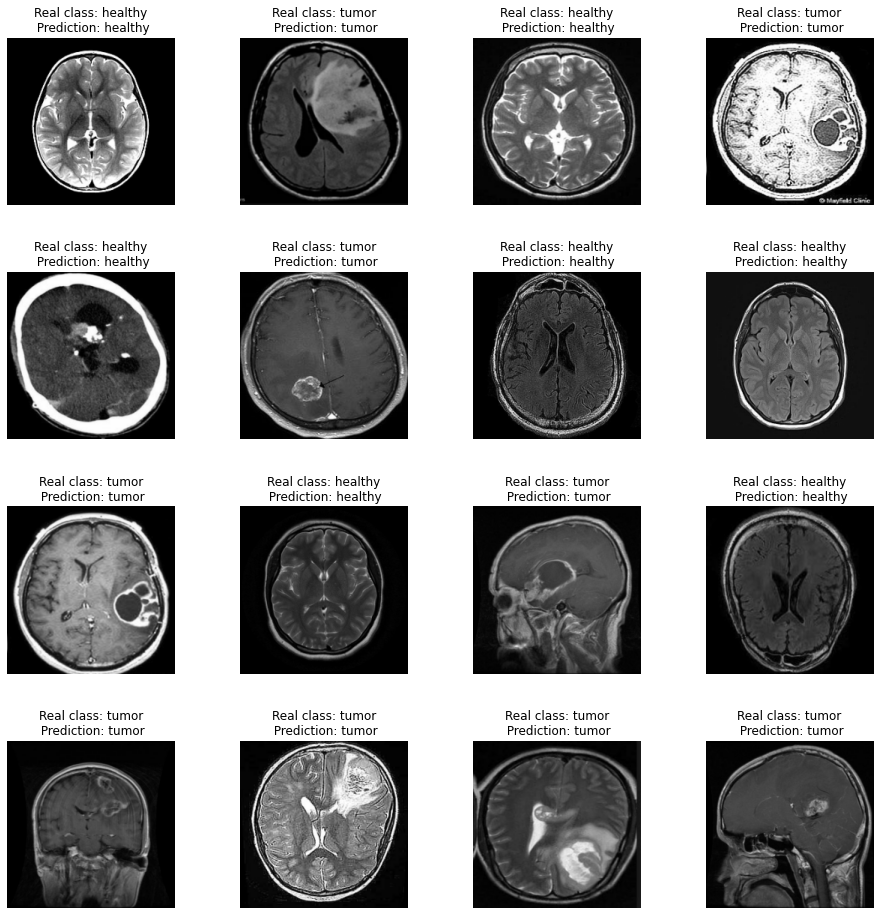

In [47]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_3[i].astype('int32'))
    
    real_y = 'healthy' if y_val_3[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_3[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [48]:
y_pred_3_binary = [1 if y > 0 else 0 for y in y_pred_3]

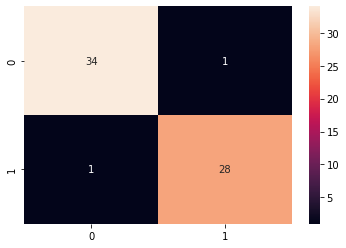

In [49]:
cf = tf.math.confusion_matrix(y_val_3, y_pred_3_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [50]:
print(classification_report(y_val_3, y_pred_3_binary))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       0.97      0.97      0.97        29

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64



## Inception_v3 - dropout increase

In [51]:
input_shape = (256, 256, 3)

In [52]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.4, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_4 = keras.Model(input, output)

model_4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 22,327,585
Trainable params: 524,801
Non-trainable params: 21,802,784
_________________________________________________________________


In [53]:
model_4.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [54]:
epochs = 60
patience = 5

In [55]:
history_4 = model_4.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/60
58/58 [==============================] - 332s 6s/step - loss: 9.0136 - binary_accuracy: 0.6503 - val_loss: 2.4267 - val_binary_accuracy: 0.7978
Epoch 2/60
58/58 [==============================] - 332s 6s/step - loss: 2.8745 - binary_accuracy: 0.7399 - val_loss: 3.1666 - val_binary_accuracy: 0.6870
Epoch 3/60
58/58 [==============================] - 334s 6s/step - loss: 3.7916 - binary_accuracy: 0.7418 - val_loss: 7.6232 - val_binary_accuracy: 0.5761
Epoch 4/60
58/58 [==============================] - 332s 6s/step - loss: 2.8606 - binary_accuracy: 0.7845 - val_loss: 1.3573 - val_binary_accuracy: 0.8576
Epoch 5/60
58/58 [==============================] - 329s 6s/step - loss: 2.7799 - binary_accuracy: 0.7772 - val_loss: 3.6089 - val_binary_accuracy: 0.7402
Epoch 6/60
58/58 [==============================] - 334s 6s/step - loss: 2.1211 - binary_accuracy: 0.8122 - val_loss: 1.5285 - val_binary_accuracy: 0.8467
Epoch 7/60
58/58 [==============================] - 337s 6s/step - los

In [56]:
history_4.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

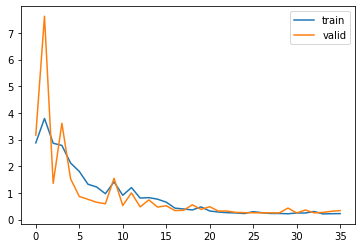

In [57]:
plt.plot(history_4.history['loss'][1:])
plt.plot(history_4.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

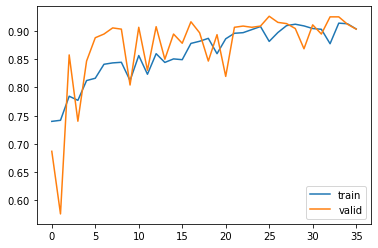

In [58]:
plt.plot(history_4.history['binary_accuracy'][1:])
plt.plot(history_4.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [59]:
x_val_4, y_val_4 = list(tfds.as_numpy(ds_val))[0]
y_pred_4 = model_4.predict(x_val_4)
sum((y_pred_4[:, 0] > 0) == y_val_4) / len(y_val_4)

0.921875

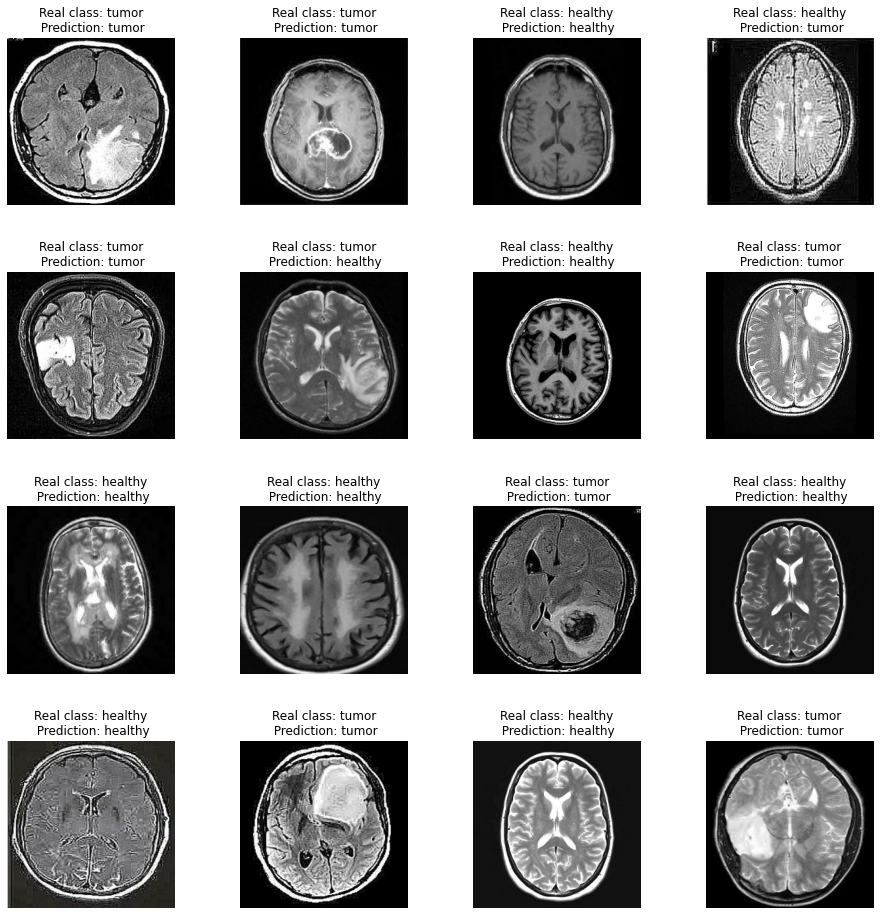

In [60]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_4[i].astype('int32'))
    
    real_y = 'healthy' if y_val_4[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_4[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [61]:
y_pred_4_binary = [1 if y > 0 else 0 for y in y_pred_4]

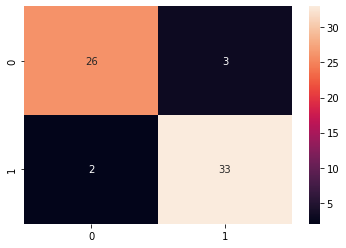

In [62]:
cf = tf.math.confusion_matrix(y_val_4, y_pred_4_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [63]:
print(classification_report(y_val_4, y_pred_4_binary))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        29
           1       0.92      0.94      0.93        35

    accuracy                           0.92        64
   macro avg       0.92      0.92      0.92        64
weighted avg       0.92      0.92      0.92        64

